In [3]:
import math
import torch
import torch.nn as nn
from torch.utils import benchmark
import torch.nn.functional as F
import numpy as np
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from itertools import combinations
# import gym
from random import randrange
from torch.nn.utils import clip_grad_norm_
# from utils_conv32 import abs_dis, ele_list_gen, cor_func_all, swap_step
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
import shutil

expert_traj = np.load('/media/wz/7AD631A4D6316195/Projects/SQS_drl/graph/expert_traj/tar8_try9_step1.npy', allow_pickle=True)
expert_traj = np.array([np.array(i) for i in expert_traj])
ind_1nn = np.load('/media/wz/7AD631A4D6316195/Projects/SQS_drl/graph/fcc_32/ind_1nn.npy')

/tmp/ipykernel_2461198/3681832443.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  expert_traj = np.array([np.array(i) for i in expert_traj])


In [6]:
def phi1(x):
    return math.sqrt(3/2)*x

def phi2(x):
    return math.sqrt(2)*(3/2*(x**2) - 1)

def cpr(val1, val2):
    val_l1 = np.array([phi1(val1), phi2(val1)])
    val_l2 = np.array([phi1(val2), phi2(val2)])
    cor_func = np.outer(val_l1, val_l2)

    return cor_func

np.sum(cpr(1,1))

3.7320508075688767

In [2]:
def draw_3d(ind_raw):
    ind_raw = np.array(ind_raw)
    plt.rcParams["figure.figsize"] = [5, 5]
    # plt.rcParams["figure.autolayout"] = True
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(ind_raw[:,0], ind_raw[:,1], ind_raw[:,2], alpha = 0.5, c = 'r')
    plt.show()

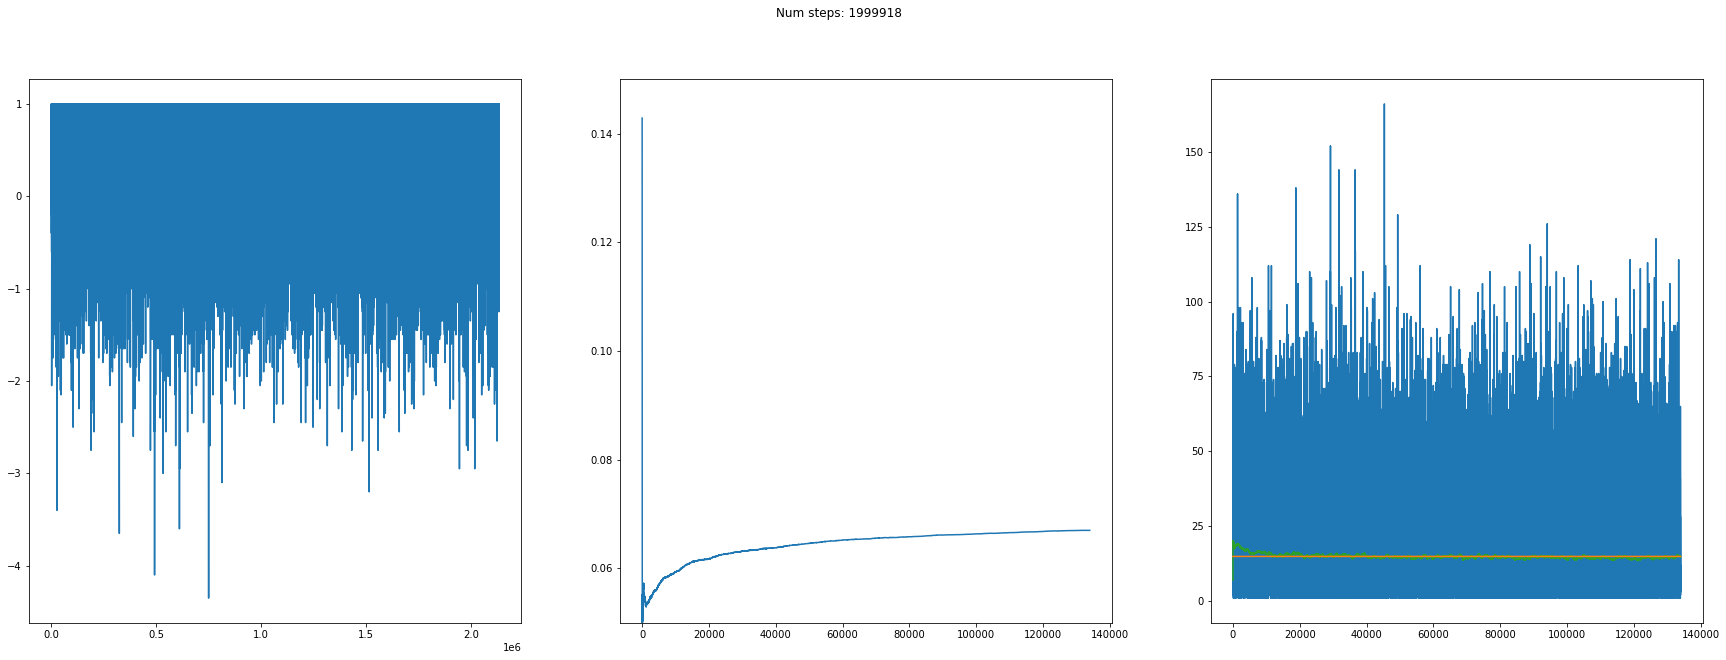

Created Directory :  /media/wz/7AD631A4D6316195/Projects/SQS_drl/graph/log/220919fc_2_try1


<Figure size 432x288 with 0 Axes>

In [7]:
import math
import torch
import torch.nn as nn
from torch.utils import benchmark
import torch.nn.functional as F
import numpy as np
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from itertools import combinations
# import gym
from random import randrange
from torch.nn.utils import clip_grad_norm_
from utils_conv32 import abs_dis, ele_list_gen, cor_func_all, swap_step
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
import shutil

expert_traj = np.load('/media/wz/7AD631A4D6316195/Projects/SQS_drl/graph/expert_traj/tar8_try9_step1.npy', allow_pickle=True)
expert_traj = np.array([np.array(i) for i in expert_traj])
ind_1nn = np.load('/media/wz/7AD631A4D6316195/Projects/SQS_drl/graph/fcc_32/ind_1nn.npy')

atom_emb = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

%matplotlib inline
def embed_ele(ele_list):
    len_ele = len(ele_list[0])
    ele_emb = torch.zeros(len_ele, 3)
    for i in range(len_ele):
        ele_emb[i][int(ele_list[i])+1] = 1
    
    return ele_emb

def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print("Created Directory : ", directory)
    else:
        print("Directory already existed : ", directory)
    return directory

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class Reward(nn.Module):
    def __init__(self, a_tilt):
        super(Reward, self).__init__()

        self.a_tilt = a_tilt
        self.output = nn.Sequential(
            layer_init(nn.Linear(34, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1),
        )
        self.gcn = nn.Sequential(
            layer_init(nn.Linear(34, 34)),
            nn.Tanh()
        )

    def forward(self, s_a):
        
        input_state = torch.mm(self.a_tilt, s_a.T).T
        s = self.gcn(input_state)
        s = torch.mm(self.a_tilt, s.T).T
        s = self.gcn(s)
        s = torch.mm(self.a_tilt, s.T).T
        s = self.gcn(s)
        s = torch.mm(self.a_tilt, s.T).T
        r = self.output(s)

        return r

class Inv_r():
    def __init__(self):
        self.lr = 1e-5
        self.mini_batchsize = 64
        self.mini_batchsize_e = 1024
        self.epoch = 4
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        a_tilt_a = np.load('/media/wz/7AD631A4D6316195/Projects/SQS_drl/graph/fcc_32/a_tilt_a34.npy')
        a_tilt_a = torch.tensor(a_tilt_a, dtype=torch.float).to(self.device)
        self.reward = Reward(a_tilt_a).to(self.device)
        self.optimizer = torch.optim.Adam(self.reward.parameters(), lr=self.lr)
    
    def reward_c(self, s_a):
        reward = self.reward(s_a).detach().cpu().numpy().flatten()
        return reward

    def update(self, p_traj, p_traj_p, e_traj):
        for _ in range(self.epoch):
            p_ind = np.random.choice(len(p_traj), self.mini_batchsize, replace=True)
            s_a = np.array([p_traj[i] for i in p_ind])
            a_prob = np.array([p_traj_p[i] for i in p_ind])
            s_a_e = np.random.choice(e_traj, self.mini_batchsize_e, replace=True) # every traj can be taken as a batch

            r_e, r_p, w_j = 0, 0, []

            for i in range(self.mini_batchsize):
                s_a_ = torch.FloatTensor(s_a[i]).to(self.device)
                a_prob_ = torch.FloatTensor(a_prob[i]).to(self.device)
                # print(torch.prod(a_prob_))
                w_ = torch.exp(torch.sum(self.reward(s_a_)))/torch.prod(a_prob_*108)
                # print(self.reward(s_a_))
                w_ = w_.detach().cpu()
                w_j.append(w_)
            
            w_j = torch.FloatTensor(w_j).to(self.device)
            sum_wj = torch.sum(w_j)
            # *Expert reward
            for i in range(self.mini_batchsize_e):
                s_a_e_ = torch.FloatTensor(s_a_e[i]).to(self.device)
                r_e += torch.sum(self.reward(s_a_e_))
            
            for i in range(self.mini_batchsize):
                s_a_i = torch.FloatTensor(s_a[i]).to(self.device)
                r_p += torch.sum(self.reward(s_a_i))*(w_j[i]/sum_wj)
            # !p_term exhibit nan!!!
            # print(s_a_e_, s_a_i)
            p_term, e_term = r_p, r_e/self.mini_batchsize_e
            reward_loss = p_term - e_term
            # print([p_term, e_term])
            # Update actor
            self.optimizer.zero_grad()
            reward_loss.backward()
            clip_grad_norm_(self.reward.parameters(), 1)
            self.optimizer.step()
            
class Actor(nn.Module):
    def __init__(self, a_tilt):
        super(Actor, self).__init__()

        self.action_s = 108
        self.a_tilt = a_tilt
        self.output = nn.Sequential(
            layer_init(nn.Linear(32, 128)),
            nn.ReLU(),
            layer_init(nn.Linear(128, self.action_s), std=0.01)
        )
        self.gcn = nn.Sequential(
            layer_init(nn.Linear(32, 32)),
            nn.ReLU()
        )

    def forward(self, atom_list, mask, replace_tensor):
        
        mask = mask.type(torch.BoolTensor).to(device)
        input_state = torch.mm(self.a_tilt, atom_list.T).T
        s = self.gcn(input_state)
        s = torch.mm(self.a_tilt, s.T).T
        s = self.gcn(s)
        s = torch.mm(self.a_tilt, s.T).T
        s = self.gcn(s)
        s = torch.mm(self.a_tilt, s.T).T
        s = self.output(s)
        # print(mask, s, replace_tensor)
        s = torch.where(mask, s, replace_tensor)
        #*Using softmax
        s = F.softmax(s, dim=1)
        # print(a_prob)
        return s

class Critic(nn.Module):
    # *value function 
    def __init__(self, a_tilt):
        super(Critic, self).__init__()

        self.a_tilt = a_tilt
        self.output = nn.Sequential(
            layer_init(nn.Linear(32, 64)),
            nn.ReLU(),
            layer_init(nn.Linear(64, 1), std=1)
        )
        self.gcn = nn.Sequential(
            layer_init(nn.Linear(32, 32)),
            nn.ReLU()
        )

    def forward(self, atom_list):

        input_state = torch.mm(self.a_tilt, atom_list.T).T
        s = self.gcn(input_state)
        s = torch.mm(self.a_tilt, s.T).T
        s = self.gcn(s)
        s = torch.mm(self.a_tilt, s.T).T
        s = self.gcn(s)
        s = torch.mm(self.a_tilt, s.T).T
        v_s = self.output(s)
    
        return v_s

class Memory():
    def __init__(self, batch_size, state_dim, device):
        self.s = np.zeros((batch_size, state_dim))
        self.mask = np.zeros((batch_size, 108))
        self.a = np.zeros((batch_size, 1))
        self.a_prob = np.zeros((batch_size, 1))
        self.r = np.zeros((batch_size, 1))
        self.s_ = np.zeros((batch_size, state_dim))
        self.dw = np.zeros((batch_size, 1))
        self.done = np.zeros((batch_size, 1))
        self.count = 0
        self.device = device

    def store(self, s, mask, a, a_prob, r, s_, dw, done):
        self.s[self.count] = s
        self.mask[self.count] = mask
        self.a[self.count] = a
        self.a_prob[self.count] = a_prob
        self.r[self.count] = r
        self.s_[self.count] = s_
        self.dw[self.count] = dw
        self.done[self.count] = done
        self.count += 1

    def numpy_to_tensor(self):
        s = torch.tensor(self.s, dtype=torch.float).to(self.device)
        mask = torch.tensor(self.mask, dtype=torch.float).to(self.device)
        a = torch.tensor(self.a, dtype=torch.long).to(self.device)  # In the discrete action space, the type of 'a' must be 'longtensor'
        a_prob = torch.tensor(self.a_prob, dtype=torch.float).to(self.device)
        r = torch.tensor(self.r, dtype=torch.float).to(self.device)
        s_ = torch.tensor(self.s_, dtype=torch.float).to(self.device)
        dw = torch.tensor(self.dw, dtype=torch.float).to(self.device)
        done = torch.tensor(self.done, dtype=torch.float).to(self.device)

        return s, mask, a, a_prob, r, s_, dw, done

class PPO():
    def __init__(self, state_dim, action_dim, batch_size):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.batch_size = batch_size
        self.mini_batch_size = 512
        self.eps_clip = 0.1
        self.K_epochs = 16
        self.GAMMA = 0.93  # discount factor
        self.LAMDA = 0.95  # GAE parameter
        self.lr = 1e-5  # learning rate
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.a_tilt = np.load('/media/wz/7AD631A4D6316195/Projects/SQS_drl/graph/fcc_32/a_tilt.npy')
        self.a_tilt = torch.tensor(self.a_tilt, dtype=torch.float).to(self.device)
        # self.action_list = np.array([[i,j] for i, j in combinations(np.arange(32), 2)])
        self.action_list = ind_1nn
        self.replacetensor = torch.tensor(-1e+8, device=self.device)
        self.actor = Actor(self.a_tilt).to(self.device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=self.lr)

        self.critic = Critic(self.a_tilt).to(self.device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=self.lr)

        self.MseLoss = nn.MSELoss()

    def swap(self, state, a_ind, mode='unsqueeze'):
        a_chosen = self.action_list[a_ind]
        a1, a2 = a_chosen
        if mode == 'unsqueeze':
            state[0][a1], state[0][a2] = state[0][a2], state[0][a1]
        elif mode == 'squeeze':
            state[a1], state[a2] = state[a2], state[a1]
        return state

    def choose_action(self, s, mask, deterministic):
        s = torch.unsqueeze(torch.tensor(s, dtype=torch.float), 0).to(self.device)
        mask = torch.unsqueeze(torch.tensor(mask, dtype=torch.float), 0)
        mask = mask.type(torch.BoolTensor).to(self.device)
        prob_weights = self.actor(s, mask, self.replacetensor).detach().cpu().numpy().flatten()  # probability distribution(numpy)
        if deterministic:  # We use the deterministic policy during the evaluating
            a = np.argmax(prob_weights)  # Select the action with the highest probability
            return a
        else:  # We use the stochastic policy during the training
            #*pi(s'|s)*alpha(s'|s)
            # while True:
                # alpha = np.random.random()
            a = np.random.choice(range(self.action_dim), p=prob_weights)  # Sample the action according to the probability distribution;
            a_prob = prob_weights[a]  # The corresponding probability
                # acceptance = a_prob/prob_inv
                # if alpha <= np.min([1, acceptance]):
                #     break
        return a, a_prob

    def update(self, memory, memory_):
        s, mask, a, a_prob, r, s_, dw, done = memory.numpy_to_tensor()

        """
            Calculate the advantage using GAE(General Advantage Estimation)
            'dw=True' menas dead or win, there is no next state s'
            'done=True' represents the terminal of an episode(dead or win or reaching the max_episode_steps). When calculating the adv, if done=True, gae=0
        """
        adv = []
        gae = 0
        s = s
        s_ = s_

        with torch.no_grad():  # adv and td_target have no gradient
            vs = self.critic(s)
            vs_ = self.critic(s_)
            deltas = r + self.GAMMA * (1.0 - dw) * vs_ - vs
            for delta, d in zip(reversed(deltas.flatten().cpu().numpy()), reversed(done.flatten().cpu().numpy())):
                gae = delta + self.GAMMA * self.LAMDA * gae * (1.0 - d)
                adv.insert(0, gae)
            adv = torch.tensor(adv, dtype=torch.float).view(-1, 1).to(self.device)
            td_target = adv + vs
            adv = ((adv - adv.mean()) / (adv.std() + 1e-5))  # The normalization will improve the performance

        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # Random sampling and no repetition. 'False' indicates that training will continue even if the number of samples in the last time is less than mini_batch_size
            for index in BatchSampler(SubsetRandomSampler(range(self.batch_size)), self.mini_batch_size, False):
                a_prob_now = self.actor(s[index], mask[index], self.replacetensor).gather(1, a[index])
                # a_prob_inv = self.actor(s_[index]).gather(1, a[index])

                # accept_for = torch.clamp(a_prob_now/a_prob_inv, max=1.0)
                # accept_inv = torch.clamp(a_prob[index]/prob_inv[index], max=1.0)

                ratios = a_prob_now / a_prob[index]

                surr1 = ratios * adv[index]  # Only calculate the gradient of 'a_prob_now' in ratios
                surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * adv[index]
                actor_loss = -torch.min(surr1, surr2).mean()
                # Update actor
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                # clip_grad_norm_(self.actor.parameters(), 10)
                self.actor_optimizer.step()
                # loss between value network and td errors (advantage)
                v_s = self.critic(s[index])
                critic_loss = self.MseLoss(td_target[index], v_s)
                # Update critic
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                # clip_grad_norm_(self.critic.parameters(), 10)
                self.critic_optimizer.step()

if __name__ == '__main__':

    number = 10
    # Set random seed
    seed = 888
    torch.manual_seed(seed)

    state_dim = 32
    action_dim = 108
    target_val = 8
    max_episode_steps = 50  # Maximum number of steps per episode
    SQS_name = 'SQS_prime'
    print("state_dim={}".format(state_dim))
    print("action_dim={}".format(action_dim))
    print("max_episode_steps={}".format(max_episode_steps))

    batch_size = 2048  # When the number of transitions in memory reaches batch_size,then update.
    max_train_steps = 2e6  # Maximum number of training steps.
    evaluate_freq = 50  # Evaluate the policy every 'evaluate_freq' steps.
    evaluate_num = 0  # Record the number of evaluations.
    evaluate_rewards = []  # Record the rewards during the evaluating.
    total_steps = 0  # Record the total steps during the training.
    r_list = []
    done_num, done_ratio, step_per_episode = 0, [], [] # Time for done.
    mean_spe = []
    traj, traj_p = [], []
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # action_list = np.array([[i,j] for i, j in combinations(np.arange(32), 2)])
    action_list = ind_1nn

    memory = Memory(batch_size, state_dim, device)
    # memory_ = Memory(batch_size, state_dim, device)
    #*Inv reward
    # reward = Inv_r()
    agent = PPO(state_dim, action_dim, batch_size)
    # Build a tensorboard
    # writer = SummaryWriter(log_dir='runs/PPO_discrete/env_{}_number_{}_seed_{}'.format(env_name[env_index], number, seed))
    r_total = 0 # Total reward when during ppo training step.
    while total_steps < max_train_steps:
        while True:
            s = ele_list_gen(1/3, 1/3, 1/3)
            cor_func_raw = cor_func_all(s)
            if 30 < cor_func_raw:
                break
        episode_steps = 0
        r_total = 0
        done = False
        traj_, traj_p_ = [], []
        # norm = cor_func_all(s)
        action_mask = np.ones(action_dim)

        while not done:
            episode_steps += 1
            a, a_prob = agent.choose_action(s, action_mask, deterministic=False)  # action and the corresponding probability
            a_ = action_list[a]
            s_, r, _, done = swap_step(a_, s, target_val=target_val, 
                                step=episode_steps, reward_type='determine')

            if done and episode_steps <= max_episode_steps:
                dw = True
            else:
                dw = False
            #*Inv reward
            # s_a = np.concatenate([s, a_/31], 0)
            # r = reward.reward_c(torch.unsqueeze(torch.FloatTensor(s_a).to(device), 0))
            # traj_.append(s_a)
            # traj_p_.append(a_prob)

            # if memory_.count < batch_size:
            #     memory_.store(s, a, a_prob, r, s_, dw, done)
            # elif done_num % 20 == 0 and memory_.count == batch_size:
            #     memory_.count = 0

            memory.store(s, action_mask, a, a_prob, r, s_, dw, done)
            action_mask = np.ones(action_dim)
            action_mask[a] = 0
            s = s_
            r_total += r
            # When the number of transitions in memory reaches batch_size,then update
            if memory.count == batch_size:
                # if memory_.count == batch_size:
                #     agent.update(memory, memory_) 
                # elif memory_.count < batch_size:
                agent.update(memory, memory) 
                memory.count = 0

            r_list.append(r)
            total_steps += 1
        
        done_num += 1
        #*Inv reward, store the trans. prob. and traj.
        # traj.append(np.array(traj_))
        # traj_p.append(np.array(traj_p_))
        # if len(traj) >= 64 and done_num % 500 == 0:
        #     reward.update(np.array(traj), np.array(traj_p))

        r_list.append(r_total)
        done_ratio.append(done_num/total_steps)
        step_per_episode.append(episode_steps)
        if done_num > 1000:
            mean_spe.append(np.mean(step_per_episode[-1000:]))
        elif done_num <= 1000:
            mean_spe.append(np.mean(step_per_episode))
        mean_spe_extend = [mean_spe[-1]]*len(mean_spe)
        if done_num % 100 == 0:
            clear_output(True)
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
            ax1.plot(r_list)
            ax2.set_ylim([0.05, 0.15])
            ax2.plot(done_ratio)
            
            ax3.plot(step_per_episode, zorder=0)
            ax3.plot(mean_spe_extend, zorder=5)
            ax3.plot(mean_spe, zorder=4)
            plt.suptitle(f'Num steps: {total_steps}')
            plt.show()

    date = 220919
    trial = 1
    fc_layer = '32, 6'
    Activation =  'Tanh'
    
    k_epoch = agent.K_epochs
    lr, mini_bs, gamma, clip, lamda = agent.lr, agent.mini_batch_size, agent.GAMMA, agent.eps_clip, agent.LAMDA
    path = f'/media/wz/7AD631A4D6316195/Projects/SQS_drl/graph/log/{date}fc_2_try{trial}'
    create_dir(path)

    f= open(path+'/hyperparams.txt',"w+")
    f.write('comment: Inv r\n')
    f.write(f'FC layers: {fc_layer}\n')
    f.write(f'Actication: {Activation}\n')
    f.write(f'lr: {lr}, mini_bs: {mini_bs}, bs: {batch_size}\n')
    f.write(f'gamma: {gamma}, clip: {clip}, lamda: {lamda}\n')
    f.write(f'k_epoch: {k_epoch}\n')

    f.close()

    np.save(path+'/done_ratio', done_ratio)
    plt.savefig(path+'/performance.png')
    torch.save(agent.actor.state_dict(), path+'/actor_params.pth')
    torch.save(agent.critic.state_dict(), path+'/critic_params.pth')
    shutil.copyfile("/media/wz/7AD631A4D6316195/Projects/SQS_drl/graph/ppo_fc_2.ipynb", 
            path+'/config.ipynb')
    shutil.copyfile("/media/wz/7AD631A4D6316195/Projects/SQS_drl/graph/utils_conv32.py", 
            path+'/utils.py')

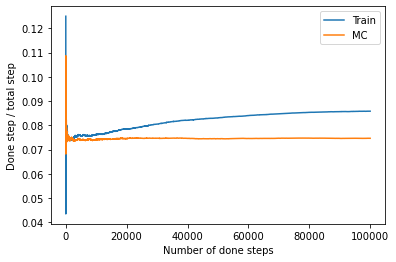

: 

In [17]:
done_ratio_train = np.load('/media/wz/7AD631A4D6316195/Projects/SQS_drl/graph/log/220820fc_2_try3/done_ratio.npy')
done_ratio_mc = np.load('/media/wz/7AD631A4D6316195/Projects/SQS_drl/graph/fcc_32/puremc_496.npy')

fig, ax = plt.subplots()
plt.plot(done_ratio_train[:len(done_ratio_mc)], label = 'Train')
plt.plot(done_ratio_mc, label = 'MC')

ax.set_xlabel('Number of done steps')
ax.set_ylabel('Done step / total step')

plt.legend()
plt.show()

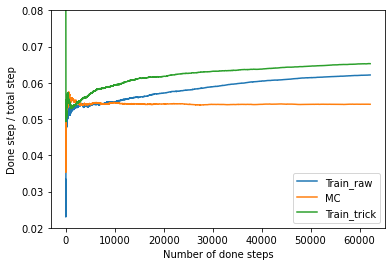

In [19]:
done_ratio_trick = np.load('/media/wz/7AD631A4D6316195/Projects/SQS_drl/graph/log/220919fc_2_try1/done_ratio.npy')
done_ratio_mc = np.load('/media/wz/7AD631A4D6316195/Projects/SQS_drl/graph/fcc_32/puremc.npy')
done_ratio_raw = np.load('/media/wz/7AD631A4D6316195/Projects/SQS_drl/graph/log/220907fc_2_try2/done_ratio.npy')

fig, ax = plt.subplots()
plt.plot(done_ratio_raw[:len(done_ratio_raw)], label = 'Train_raw')
plt.plot(done_ratio_mc[:len(done_ratio_raw)], label = 'MC')
plt.plot(done_ratio_trick[:len(done_ratio_raw)], label = 'Train_trick')

ax.set_xlabel('Number of done steps')
ax.set_ylabel('Done step / total step')
ax.set_ylim([0.02, 0.08])

plt.legend()
plt.show()

In [16]:
np.max(done_ratio_trick[500:])/done_ratio_mc[-1]

1.2432163263532436

In [17]:
np.max(done_ratio_raw[500:])/done_ratio_mc[-1]

1.1533810863758505

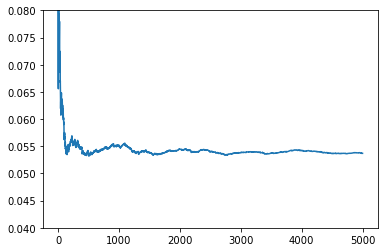

5000 93116


In [32]:
total_step, done_num = 1, 0
done_list, step_list = [], []

for i in range(5000):
    while True:
        ele_list = ele_list_gen(1/3, 1/3, 1/3)
        cor_func = cor_func_all(ele_list)

        if cor_func > 30:
            break

    while True:
        a_ind = np.random.choice(range(108))
        action = ind_1nn[a_ind]
        ele_list_n, r, cor_func_n, _ = swap_step(action, ele_list, 8, 1)

        if cor_func_n < 8:
            done_num += 1
            total_step += 1
            break

        total_step += 1

    done_list.append(done_num)
    step_list.append(done_num/total_step)
    
    if done_num % 100 == 0:
        clear_output(True)
        fig, ax = plt.subplots()
        ax.set_ylim([0.04, 0.08])
        plt.plot(done_list, step_list)
        plt.show()

print(done_num, total_step)

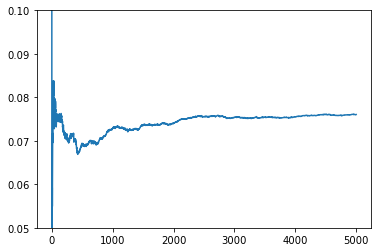

5000 65752


In [30]:
total_step, done_num = 1, 0
done_list, step_list = [], []
action_list = np.array([[i,j] for i, j in combinations(np.arange(32), 2)])

for i in range(5000):
    while True:
        ele_list = ele_list_gen(1/3, 1/3, 1/3)
        cor_func = cor_func_all(ele_list)

        if cor_func > 30:
            break

    while True:
        a_ind = np.random.choice(range(496))
        action = action_list[a_ind]
        ele_list_n, r, cor_func_n, _ = swap_step(action, ele_list, 8, 1)

        if cor_func_n < 8:
            done_num += 1
            total_step += 1
            break

        total_step += 1
    
    done_list.append(done_num)
    step_list.append(done_num/total_step)
    
    if done_num % 100 == 0:
        clear_output(True)
        fig, ax = plt.subplots()
        ax.set_ylim([0.05, 0.1])
        plt.plot(done_list, step_list)
        plt.show()

print(done_num, total_step)

In [14]:
def evaluate_policy(agent, target_val):
    times = 1
    evaluate_reward = 0
    for _ in range(times):
        # s = env.reset()
        while True:
            s = ele_list_gen(1/3, 1/3, 1/3)
            cor_func_raw = cor_func_all(s)
            if cor_func_raw > 30:
                print(cor_func_raw)
                break
        done = False
        episode_reward = 0
        cor_func_list = []

        while not done:
            a = agent.choose_action(s, deterministic=True) # argmax
            a_ = action_list[a]
            # s_, r, done, _ = env.step(a)
            s_, r, _, done = swap_step(a_, s, target_val=target_val, step = 1,  reward_type = 'sigmoid')
            cor_func = cor_func_all(s_)
            episode_reward += r
            s = s_
            cor_func_list.append(cor_func)
            # if len(cor_func_list) % 50 == 0:
            #     clear_output(True)
            #     plt.title(f'num_trial {len(cor_func_list)}')
            #     plt.plot(cor_func_list)
            #     plt.show()
            print(cor_func)
        
        evaluate_reward += episode_reward

    plt.plot(cor_func_list)
    
    return int(evaluate_reward / times)

In [37]:
evaluate_policy(agent, target_val=target_val)

33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.46410161513776
33.4641016

KeyboardInterrupt: 

In [4]:
state = ele_list_e_prime(1/3, 1/3, 1/3)
action_list = []
matrix = np.zeros((3,5))-1
ind_cr = np.where(state == 0.)[0]
ind_co = np.where(state == 1.)[0]
ind_ni = np.where(state == -1.)[0]
len_cr = len(ind_cr)
len_co = len(ind_co)
len_ni = len(ind_ni)
matrix[0][:len_cr] = ind_cr
matrix[1][:len_co] = ind_co
matrix[2][:len_ni] = ind_ni
ind_all = np.argwhere(matrix != -1)
for i1, i2 in combinations(ind_all, 2):
    if i1[0] != i2[0]:
        action_list.append([i1, i2])
action_list = np.array(action_list)

print(state)
print(matrix)

[-1.  0.  0. -1. -1.  1.  0.  1.  1. -1.  0.  1.  1. -1.]
[[ 1.  2.  6. 10. -1.]
 [ 5.  7.  8. 11. 12.]
 [ 0.  3.  4.  9. 13.]]
